# 第16章　CNNを使った時系列のフィルタリング

前章では、長短期記憶(LSTM)を調べた。本章では、畳み込みニューラルネットワーク(CNN)を調べる。

## 16.1 　畳み込みニューラルネットワーク(CNN)を調べる
畳み込みニューラルネットワーク(CNN)は、畳み込み演算を利用するディープラーニングアーキテクチャである。

畳み込み演算とは？
２つの関数を用いた演算で、１つ目の関数の形状が２つ目の関数によってどのように変更されるのかを表す、３つ目の関数を生成する。CNNではこの演算が入力関数とカーネルの間で実行される。

入力関数：元のデータ(画像や信号など)を表す関数。

カーネル：元のデータに作用して、特徴を抽出するための小さな行列。特徴量行列の上に配置される行列であり、フィルタとも呼ぶ。

つまり、生成された新しい関数は元のデータの特定の特徴が強調されたもの。

下の図では、時間軸に沿ってカーネルが動き、カーネルと特徴量のドット積が計算され、特徴量が減り、正則化と異常値のフィルタリングが実現される。

<img src="スクリーンショット 2025-06-24 110716.png">

実際に理解するために、特徴量とカーネルが１つずつの単純な例を考える。

<img src="スクリーンショット 2025-06-24 111451.png">

カーネルは最初に特徴量ベクトルの先頭に揃え、カーネルとそれに揃っている特徴量ベクトルの値との間でドット積が計算され、それが完了するとカーネルが時間ステップ１つ分右にシフトし、この流れをカーネルが特徴量ベクトルの終わりまで繰り返す。

この例では、長さ６の特徴量ベクトルと長さ３のカーネルから、長さ４の出力ベクトルが生成された。一般に畳み込み演算における出力ベクトルの長さは次のように求められる。

### 出力の長さ＝入力の長さ－カーネルの長さ＋１

カーネルは右方向にのみ移動するので、これは１次元の畳み込みであり、カーネルは時間次元でしか移動できないので時系列予測に使われる。

畳み込み層では、特徴量セットの長さが短くなる(入力の長さ ≥ 出力の長さ)。 また、畳み込みを何回も実行すると、特徴量空間が次第に小さくなる。

ex.入力の長さを９、カーネルの長さを２として、出力の長さを計算

１回目：9-2+1=8 ２回目：8-2+1=7 ３回目：7-2+1=6

これでは、ネットワーク内の層の数が制限され、その過程で情報が余分に失われる可能性があり、必ずしも望ましいことではない。

これを防ぐために、パディングを行う。

パディングは、特徴量ベクトルの前後に値を追加し、出力を入力と同じ長さに保つもの。使われる値は０。

下の図はパディングの例である。

<img src="スクリーンショット 2025-06-24 120313.png">

<img src="スクリーンショット 2025-06-24 120325.png">

## 16.2　CNNモデルの実装

In [13]:
import datetime
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras import layers,Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Flatten, Reshape,Dropout, BatchNormalization, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
from tensorflow.keras.layers import SimpleRNN
tf.random.set_seed(42)
np.random.seed(42)
print(tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import importlib.util
import sys
# japanize-matplotlib が未インストールなら pip install
if importlib.util.find_spec("japanize_matplotlib") is None:
  !pip install japanize-matplotlib
# 必要なライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from CH13_14 import DataWindow,BaselineModel,model_predict,plot_model_prediction,compile_and_fit

# CH12のデータのロード from GitHubのrawデータURL
u1 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_train.csv"
u2 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_val.csv"
u3 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/CH1213_test.csv"
# データの読み込み
train_df = pd.read_csv(u1)
val_df = pd.read_csv(u2)
test_df = pd.read_csv(u3)
train_df.head()

print(train_df.shape, val_df.shape, test_df.shape)
column_indices = {name: i for i, name in enumerate(train_df.columns)}
print(column_indices)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2.17.0
GPU Available: []
(12285, 5) (3510, 5) (1756, 5)
{'temp': 0, 'clouds_all': 1, 'traffic_volume': 2, 'day_sin': 3, 'day_cos': 4}


In [2]:
val_performance= {'Full-DNN': (0.0019, 0.031),
  'RNN': (0.0016, 0.0283),
  'LSTM': (0.0014, 0.0265),
  'Simple Transformer': (0.0018, 0.0305)
  }
test_performance={'Full-DNN': (0.0015, 0.0281),
  'RNN': (0.0014, 0.0272),
  'LSTM': (0.0011, 0.0246),
  'Simple Transformer': (0.0015, 0.028)
  }

w = DataWindow(input_width=24,label_width=1,shift=1,stride=1,
    train_df=train_df,val_df=val_df,test_df=test_df,
    label_columns=['traffic_volume'])

# CH.16 CNN



## 16.2 CNNの実装

### Single-step model

In [3]:
# input_shapeは DataWindow から取得した形 (例: (24, 5))
input_shape = w.train.element_spec[0].shape[1:]
label_width = w.label_width  # label_width は1など任意の予測ステップ数

KERNEL_WIDTH=3

cnn = Sequential([
    Conv1D(filters=32,
           kernel_size=KERNEL_WIDTH,
           activation='relu'),        # 非線形特徴抽出
    Flatten(),                        # 畳み込み出力を1次元に変換
    Dense(32, activation='relu'),     # 非線形層
    Dense(label_width),               # 線形出力層（活性化なし）
    Reshape((label_width, 1))
])

#　モデルの訓練
history = compile_and_fit(cnn,w)

# 評価スコアを辞書に保存
val_loss, val_mae = cnn.evaluate(w.val, verbose=0)
test_loss, test_mae = cnn.evaluate(w.test, verbose=0)
val_performance["CNN"] = (round(val_loss,4), round(val_mae,4))
test_performance["CNN"] = (round(test_loss,4),round(test_mae,4))
val_performance,test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0204 - mean_absolute_error: 0.0984 - val_loss: 0.0063 - val_mean_absolute_error: 0.0542
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0047 - mean_absolute_error: 0.0488 - val_loss: 0.0035 - val_mean_absolute_error: 0.0429
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0412 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - mean_absolute_error: 0.0368 - val_loss: 0.0022 - val_mean_absolute_error: 0.0332
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - mean_absolute_error: 0.0355 - val_loss: 0.0021 - val_mean_absolute_error: 0.0328
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023 - mean_absolute_error: 0.0337 - val_loss: 0.0018 - val_mean_absolute_error: 0.0291
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0

({'Full-DNN': (0.0019, 0.031),
  'RNN': (0.0016, 0.0283),
  'LSTM': (0.0014, 0.0265),
  'Simple Transformer': (0.0018, 0.0305),
  'CNN': (0.0018, 0.0299)},
 {'Full-DNN': (0.0015, 0.0281),
  'RNN': (0.0014, 0.0272),
  'LSTM': (0.0011, 0.0246),
  'Simple Transformer': (0.0015, 0.028),
  'CNN': (0.0015, 0.0281)})

#### CNN + LSTM

In [4]:
# input_shapeは DataWindow から取得した形 (例: (24, 5))
input_shape = w.train.element_spec[0].shape[1:]
label_width = w.label_width  # label_width は1など任意の予測ステップ数

KERNEL_WIDTH=3

cnn_lstm=Sequential([
    Conv1D(filters=32,
           kernel_size=KERNEL_WIDTH,
           activation='relu'),        # 非線形特徴抽出
    LSTM(32, return_sequences=False),  # 最後のステップのみ取得=デフォルト
    Dense(label_width),
    Reshape((label_width, 1))
])

history = compile_and_fit(cnn_lstm,w)

# 評価スコアを辞書に保存
val_loss, val_mae = cnn_lstm.evaluate(w.val, verbose=0)
test_loss, test_mae = cnn_lstm.evaluate(w.test, verbose=0)
val_performance["CNN+LSTM"] = (round(val_loss,4), round(val_mae,4))
test_performance["CNN+LSTM"] = (round(test_loss,4),round(test_mae,4))
val_performance,test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0354 - mean_absolute_error: 0.1364 - val_loss: 0.0086 - val_mean_absolute_error: 0.0665
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0077 - mean_absolute_error: 0.0643 - val_loss: 0.0052 - val_mean_absolute_error: 0.0542
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0048 - mean_absolute_error: 0.0518 - val_loss: 0.0030 - val_mean_absolute_error: 0.0408
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0038 - mean_absolute_error: 0.0459 - val_loss: 0.0033 - val_mean_absolute_error: 0.0443
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0034 - mean_absolute_error: 0.0429 - val_loss: 0.0034 - val_mean_absolute_error: 0.0436
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0400 - val_loss: 0.0023 - val_mean_absolute_error: 0.0364
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0026 - mean_absolute_error: 0.0

({'Full-DNN': (0.0019, 0.031),
  'RNN': (0.0016, 0.0283),
  'LSTM': (0.0014, 0.0265),
  'Simple Transformer': (0.0018, 0.0305),
  'CNN': (0.0018, 0.0299),
  'CNN+LSTM': (0.0015, 0.0282)},
 {'Full-DNN': (0.0015, 0.0281),
  'RNN': (0.0014, 0.0272),
  'LSTM': (0.0011, 0.0246),
  'Simple Transformer': (0.0015, 0.028),
  'CNN': (0.0015, 0.0281),
  'CNN+LSTM': (0.0013, 0.0267)})

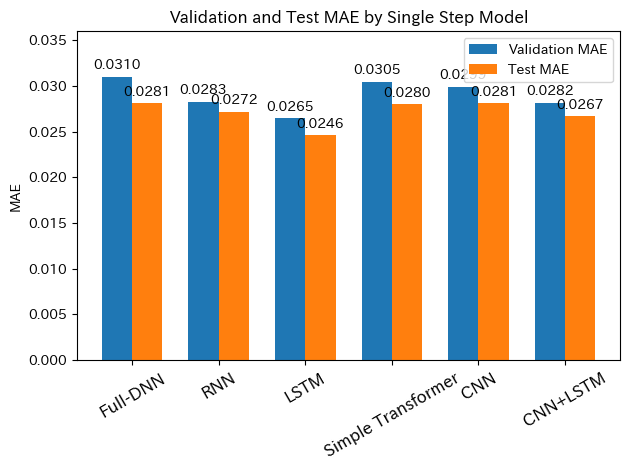

In [5]:
# MAE（1番目の指標）を抽出
labels = list(val_performance.keys())
val_mae = [val_performance[k][1] for k in labels]
test_mae = [test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
val_bars = ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
test_bars = ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

# 数値ラベルの追加
for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0005,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0005,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 追加：Y軸の上限を調整して重なりを防ぐ
max_val = max(max(val_mae), max(test_mae))
ax.set_ylim(0, max_val + 0.005)

# 軸・凡例設定
ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Single Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, rotation=30)
ax.legend()
plt.tight_layout()
plt.show()


# 第17章　予測を使ってさらに予測を行う
本章ではマルチステップモデルにのみに焦点を当て、自己回帰LSTM(ARLSTM)モデルの一般的なアーキテクチャについて調べる。


## 17.1　ARLSTMアーキテクチャを調べる
自己回帰LSTM(ARLSTM)：予測値を入力に使って次の予測値を生成する方式

つまり、１ステップ先を予測し、その出力を次のステップの入力に加えて繰り返すことでマルチステップ予測を可能にする。

これまでのマルチステップモデルは過去24時間($t_0～t_{23}$)の時系列データを入力し、時系列順にLSTM層を通過して、最終ステップの要約情報を使って未来の24時間($t_{24}～t_{47}$)を一括で予測していた。

<img src="スクリーンショット 2025-06-24 141119.png">

しかし、もっと長いor短い場合を考えると、モデルを再び訓練する必要があり、手間がかかる。そこで、ARLSTMアーキテクチャを使う。

<img src="スクリーンショット 2025-06-24 143643.png">

最初に$t_0～t_{23}$のデータを入力し、最初の出力$t_{24}$を生成。次に$t_1～t_{23}$と$t_{24}$を入力し、$t_{25}$を生成。これを目的の長さまで繰り返す。

このモデルの課題として、誤差が蓄積しやすい点がある。それは、出力を入力に使いまわすので、1つの予測ミスがそのあとに影響を与えてしまうからである。

# CH. 17  Autoregressive LSTM

## Multi-step Model

In [6]:

w_ms=DataWindow(input_width=24,label_width=24,shift=1,stride=1,
    train_df=train_df,val_df=val_df,test_df=test_df,
    label_columns=['traffic_volume'])

ms_val_performance={}
ms_test_performance={}

In [7]:
# データセットの input_shape を取得
input_shape = w_ms.train.element_spec[0].shape[1:]  # 例：(24, 5)
label_width=w_ms.label_width

full_dnn = Sequential([
    Flatten(input_shape=input_shape),      # [batch, 24, 5] → [batch, 120]
    Dense(32, activation='relu'),          # [batch, 120] → [batch, 32]
    Dense(label_width),  # [batch, 24]
    Reshape((label_width, 1))              # [batch, 24] → [batch, 24, 1]
])

#　モデルの訓練
history = compile_and_fit(full_dnn,w_ms)

# 評価スコアを辞書に保存
val_performance={}
test_performance={}
val_loss, val_mae = full_dnn.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = full_dnn.evaluate(w_ms.test, verbose=0)
ms_val_performance["Full-DNN"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["Full-DNN"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0851 - mean_absolute_error: 0.2091 - val_loss: 0.0146 - val_mean_absolute_error: 0.0927
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - mean_absolute_error: 0.0815 - val_loss: 0.0059 - val_mean_absolute_error: 0.0593
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0049 - mean_absolute_error: 0.0536 - val_loss: 0.0029 - val_mean_absolute_error: 0.0415
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027 - mean_absolute_error: 0.0393 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - mean_absolute_error: 0.0317 - val_loss: 0.0013 - val_mean_absolute_error: 0.0266
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0014 - mean_absolute_error: 0.0273 - val_loss: 0.0010 - val_mean_absolute_error: 0.0231
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - mean_absolute_error: 0.0

({'Full-DNN': (0.0003, 0.011)}, {'Full-DNN': (0.0003, 0.0104)})

In [8]:
# input_shapeは DataWindow から取得した形 (例: (24, 5))
input_shape = w_ms.train.element_spec[0].shape[1:]
label_width = w_ms.label_width  # label_width は1など任意の予測ステップ数


simple_rnn = Sequential([
    SimpleRNN(units=32, input_shape=input_shape),
    Dense(units=label_width),
    Reshape((label_width, 1))
])

#　モデルの訓練
history = compile_and_fit(simple_rnn,w_ms)

# 評価スコアを辞書に保存
val_loss, val_mae = simple_rnn.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = simple_rnn.evaluate(w_ms.test, verbose=0)
ms_val_performance["RNN"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["RNN"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1035 - mean_absolute_error: 0.2373 - val_loss: 0.0237 - val_mean_absolute_error: 0.1176
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0196 - mean_absolute_error: 0.1048 - val_loss: 0.0142 - val_mean_absolute_error: 0.0879
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0115 - mean_absolute_error: 0.0802 - val_loss: 0.0075 - val_mean_absolute_error: 0.0655
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0062 - mean_absolute_error: 0.0593 - val_loss: 0.0045 - val_mean_absolute_error: 0.0502
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0041 - mean_absolute_error: 0.0477 - val_loss: 0.0030 - val_mean_absolute_error: 0.0406
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0400 - val_loss: 0.0022 - val_mean_absolute_error: 0.0346
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0

({'Full-DNN': (0.0003, 0.011), 'RNN': (0.0003, 0.0102)},
 {'Full-DNN': (0.0003, 0.0104), 'RNN': (0.0003, 0.0099)})

In [9]:
# input_shapeは DataWindow から取得した形 (例: (24, 5))
input_shape = w_ms.train.element_spec[0].shape[1:]
label_width = w_ms.label_width  # label_width は1など任意の予測ステップ数

lstm = Sequential([
    LSTM(32, input_shape=input_shape),
    Dense(label_width),
    Reshape((label_width, 1))
])

#　モデルの訓練
history = compile_and_fit(lstm,w_ms)

# 評価スコアを辞書に保存
val_loss, val_mae = lstm.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = lstm.evaluate(w_ms.test, verbose=0)
ms_val_performance["LSTM"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["LSTM"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0842 - mean_absolute_error: 0.2148 - val_loss: 0.0125 - val_mean_absolute_error: 0.0852
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0101 - mean_absolute_error: 0.0769 - val_loss: 0.0063 - val_mean_absolute_error: 0.0613
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0586 - val_loss: 0.0047 - val_mean_absolute_error: 0.0525
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0047 - mean_absolute_error: 0.0523 - val_loss: 0.0039 - val_mean_absolute_error: 0.0474
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0473 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0033 - mean_absolute_error: 0.0427 - val_loss: 0.0027 - val_mean_absolute_error: 0.0384
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0029 - mean_absolute_error: 0.0

({'Full-DNN': (0.0003, 0.011),
  'RNN': (0.0003, 0.0102),
  'LSTM': (0.0007, 0.019)},
 {'Full-DNN': (0.0003, 0.0104),
  'RNN': (0.0003, 0.0099),
  'LSTM': (0.0006, 0.0174)})

In [10]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense

class AR_LSTM(Model):
    def __init__(self, units, out_steps, num_features):
        super().__init__()
        self.out_steps = out_steps

        # LSTM層（RNNを直接使用し簡略化）
        self.lstm = LSTM(units, return_state=False, return_sequences=False)
        
        # 出力層（Dense）
        self.dense = Dense(num_features)


    def call(self, inputs):
        predictions = []

        # 最初の入力には真の系列を使って予測
        prediction = self.dense(self.lstm(inputs))
        predictions.append(prediction)

        # その後の自己回帰予測（out_steps - 1回繰り返す）
        for _ in range(1, self.out_steps):
            # 最新の予測を系列の末尾に追加し、系列を更新（長さを保つ）
            inputs = tf.concat([inputs[:, 1:, :], tf.expand_dims(prediction, axis=1)], axis=1)

            # 更新された入力系列で次の予測を得る
            prediction = self.dense(self.lstm(inputs))

            # 予測結果を保存
            predictions.append(prediction)

        # 全ステップの予測をTensorとしてまとめる
        predictions = tf.stack(predictions, axis=1)

        return predictions


In [11]:
# パラメータ設定
units = 32
out_steps = w_ms.label_width
num_features = len(w_ms.column_indices) 

# モデルのインスタンス化
ar_lstm = AR_LSTM(units, out_steps, num_features)
history = compile_and_fit(ar_lstm,w_ms)

# 評価スコアを辞書に保存
val_loss, val_mae = ar_lstm.evaluate(w_ms.val, verbose=0)
test_loss, test_mae = ar_lstm.evaluate(w_ms.test, verbose=0)
ms_val_performance["AR_LSTM"] = (round(val_loss,4), round(val_mae,4))
ms_test_performance["AR_LSTM"] = (round(test_loss,4),round(test_mae,4))
ms_val_performance,ms_test_performance

Epoch 1/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 88s 156ms/step - loss: 0.0796 - mean_absolute_error: 0.2159 - val_loss: 0.0062 - val_mean_absolute_error: 0.0599
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 57s 147ms/step - loss: 0.0053 - mean_absolute_error: 0.0549 - val_loss: 0.0035 - val_mean_absolute_error: 0.0442
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - loss: 0.0033 - mean_absolute_error: 0.0419 - val_loss: 0.0024 - val_mean_absolute_error: 0.0352
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - loss: 0.0025 - mean_absolute_error: 0.0359 - val_loss: 0.0023 - val_mean_absolute_error: 0.0347
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - loss: 0.0021 - mean_absolute_error: 0.0324 - val_loss: 0.0017 - val_mean_absolute_error: 0.0286
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - loss: 0.0018 - mean_absolute_error: 0.0298 - val_loss: 0.0015 - val_mean_absolute_error: 0.0270
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - loss: 0.0016 - mea

({'Full-DNN': (0.0003, 0.011),
  'RNN': (0.0003, 0.0102),
  'LSTM': (0.0007, 0.019),
  'AR_LSTM': (0.0008, 0.0195)},
 {'Full-DNN': (0.0003, 0.0104),
  'RNN': (0.0003, 0.0099),
  'LSTM': (0.0006, 0.0174),
  'AR_LSTM': (0.0007, 0.0189)})

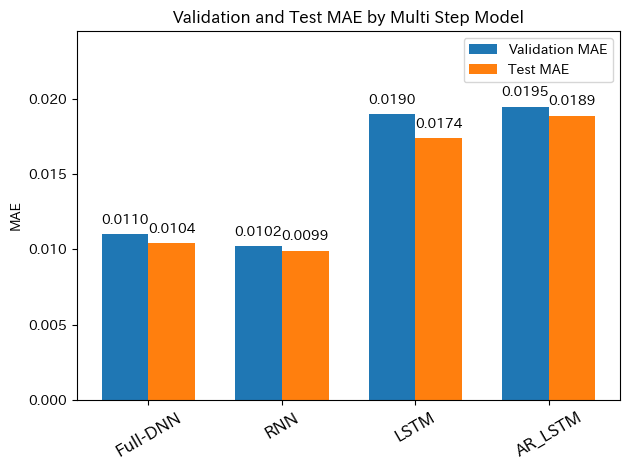

In [12]:
# MAE（1番目の指標）を抽出
labels = list(ms_val_performance.keys())
val_mae = [ms_val_performance[k][1] for k in labels]
test_mae = [ms_test_performance[k][1] for k in labels]

# 棒グラフの描画
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
val_bars = ax.bar([i - width/2 for i in x], val_mae, width, label='Validation MAE')
test_bars = ax.bar([i + width/2 for i in x], test_mae, width, label='Test MAE')

# 数値ラベルの追加
for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0005,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.0005,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10)

# 追加：Y軸の上限を調整して重なりを防ぐ
max_val = max(max(val_mae), max(test_mae))
ax.set_ylim(0, max_val + 0.005)

# 軸・凡例設定
ax.set_ylabel('MAE')
ax.set_title('Validation and Test MAE by Multi Step Model')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, rotation=30)
ax.legend()
plt.tight_layout()
plt.show()
